In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def generate_samples(n, n_features, random_seed):
    rng = np.random.default_rng(random_seed)
    p = rng.uniform(0.25, 0.75, n_features)
    X = rng.binomial(1, p, (n, n_features))
    y = rng.binomial(1, 0.5, n)
    return X, y

In [13]:
from Project.feature.FastCMIM import fast_cmim
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel, SelectorMixin
from sklearn.linear_model import LassoCV
from Project.feature.CMIM import CMIMSelector
from Project.feature.JMI import JMISelector


def evaluate_single_method(selector: SelectorMixin, name):
    if name != "FastCMIM":
        selected_mask = selector._get_support_mask()
    else:
        selected_mask = selector
    true_mask = np.zeros_like(selected_mask)
    return [{
        'method': name,
        'accuracy': accuracy_score(true_mask, selected_mask),
        'n_selected': sum(selected_mask)
    }]


def evaluate_methods(n, n_features):
    results = []
    CMIM_max_features = 20
    for random_seed in tqdm(range(20)):
        X, y = generate_samples(n, n_features, random_seed=random_seed)
        # JMI
        jmi_selector = JMISelector()
        jmi_selector.fit(X, y)
        jmi_selector.get_support()
        results += evaluate_single_method(jmi_selector, "JMI")
        # CMIM
        cmin_selector = CMIMSelector(max_iter=CMIM_max_features)
        cmin_selector.fit(X, y)
        results += evaluate_single_method(cmin_selector, "CMIM")
        # LASSO
        lasso = LassoCV(cv=5, random_state=random_seed, selection='random', alphas=np.linspace(0.01, 0.05, 100),
                        max_iter=10_000, tol=1e-4)
        lasso = lasso.fit(X, y)
        lasso_selector = SelectFromModel(lasso, prefit=True)
        results += evaluate_single_method(lasso_selector, "LASSO")
        # SVM
        svm = LinearSVC(penalty='l1', dual=False, max_iter=100_000)
        grid = {'C': [10 ** i for i in range(-5, 5)]}
        svm_grid_search = GridSearchCV(svm, param_grid=grid, scoring='f1').fit(X, y)
        best_svm = svm_grid_search.best_estimator_.fit(X, y)
        svm_selector = SelectFromModel(best_svm)
        results += evaluate_single_method(svm_selector, "SVM")

        # FastCMIM
        cmim_selected, scores = fast_cmim(X, y, n_selected_features=CMIM_max_features)
        selected = (np.cumsum(scores) / np.sum(scores)) < 0.99
        cmim_mask = np.zeros(X.shape[1])
        cmim_mask[cmim_selected[selected]] = 1
        results += evaluate_single_method(cmim_mask, "FastCMIM")
    return results

In [14]:
results = []
ns = [50, 100, 250, 500, 1000, 2500, 5000]
for n in ns:
    results_n = pd.DataFrame(evaluate_methods(n=n, n_features=25))
    results_n['n'] = n
    results += [results_n]
results = pd.concat(results)

 15%|█▌        | 3/20 [00:04<00:24,  1.47s/it]E:\Studies\DataScience-3sem\MathematicalUnderpinningsOfMachineLearning\venv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 25%|██▌       | 5/20 [00:07<00:22,  1.50s/it]E:\Studies\DataScience-3sem\MathematicalUnderpinningsOfMachineLearning\venv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Studies\DataScience-3sem\MathematicalUnderpinningsOfMachineLearning\venv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 55%|█████▌    | 11/20 [00:17<00:15,  1.76s/it]E:\Studies\DataScience-3sem\MathematicalUnderpinningsOfMachineLearning\venv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number o

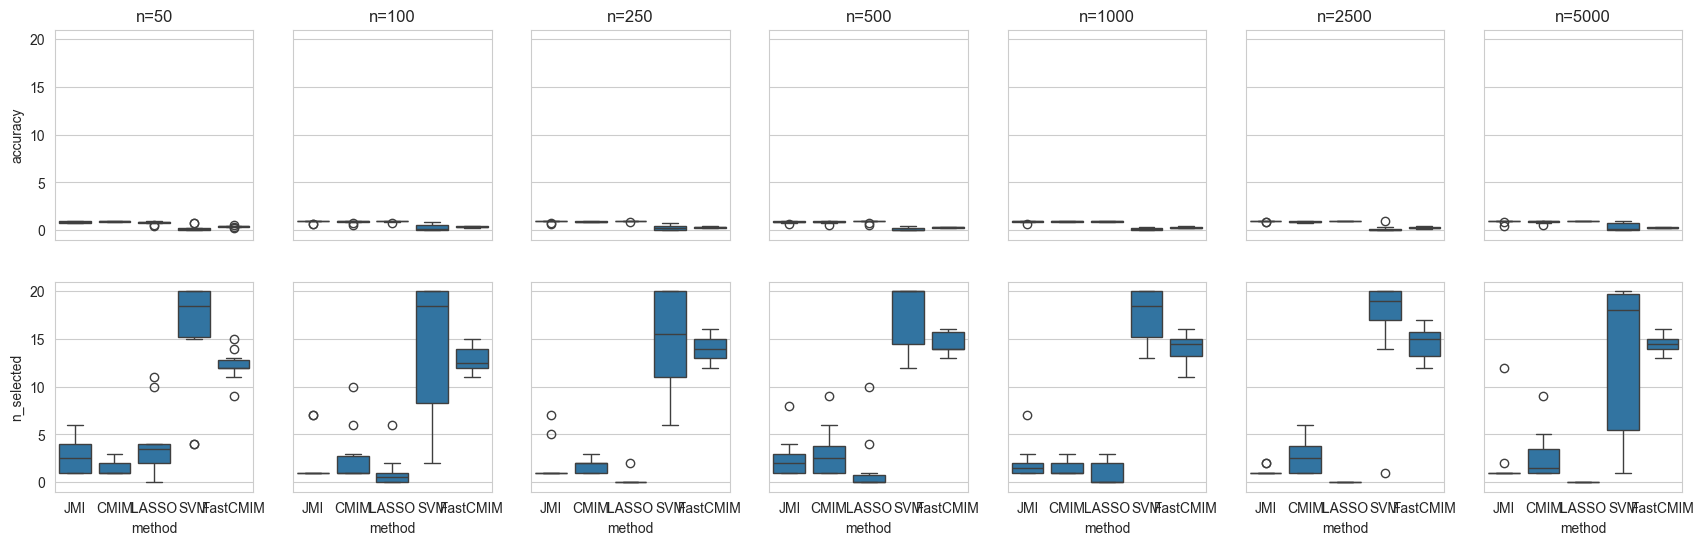

In [11]:
fig, ax = plt.subplots(2, len(ns), sharex=True,  figsize=(21, 6))
for i, n in enumerate(ns):
    sns.boxplot(results[results['n'] == n], x='method', y='accuracy', ax=ax[0][i])
    sns.boxplot(results[results['n'] == n], x='method', y='n_selected', ax=ax[1][i])
for ax_, col in zip(ax[0], [f"n={n}" for n in ns]):
    ax_.set_title(col)

<Axes: xlabel='n', ylabel='n_selected'>

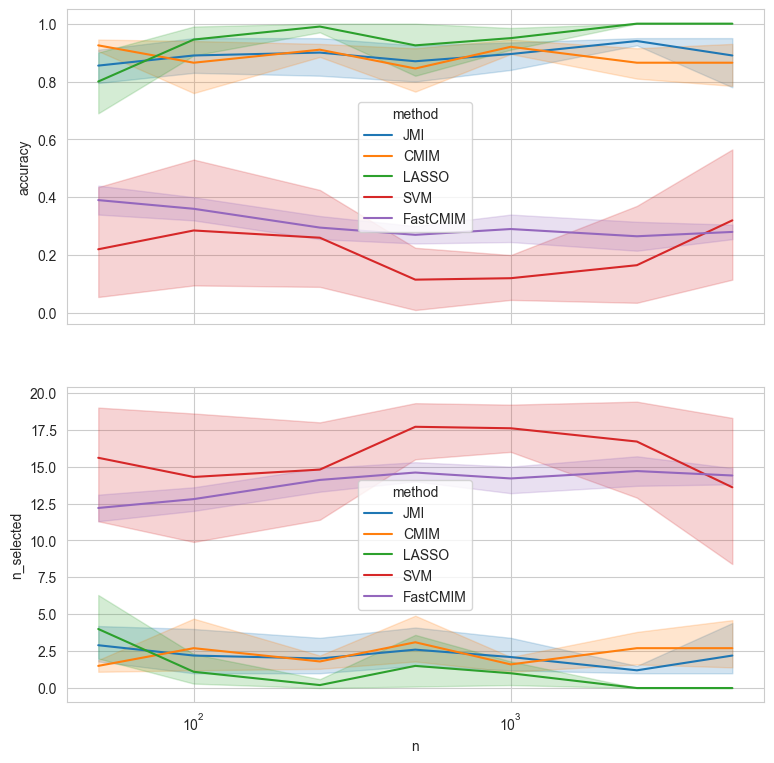

In [12]:
fig, ax = plt.subplots(2, sharex=True, figsize=(9, 9))
for i in range(2):
    ax[i].set_xscale('log')
sns.lineplot(results, x='n', y='accuracy', hue='method', ax=ax[0])
sns.lineplot(results, x='n', y='n_selected', hue='method', ax=ax[1])